(n, k, α) = (20, 6, 0.05) = (20, 6, 0.05)
post = Beta(1 + k, (1 + n) - k) = Beta{Float64}(α=7.0, β=15.0)
ci = confint(n, k, α) = [0.1317818701675779, 0.5165046145299311]
bci = hdi(post, α) = [0.13606948377291903, 0.5092998691378794]
h = exp(-(quantile(Chisq(1), 1 - α)) / 2) = 0.14650006448608427
bh = pdf(post, bci[begin]) / pdf(post, mode(post)) = 0.16564096029047545


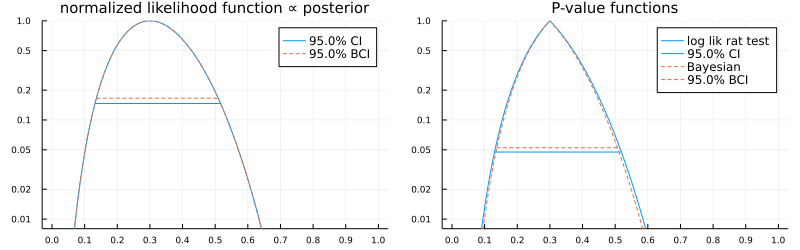

In [1]:
using Distributions
using Optim
using Roots
using StatsFuns
using StatsPlots
default(titlefontsize=10, tickfontsize=6, guidefontsize=9)

function hdi(dist::ContinuousUnivariateDistribution, α = 0.05; alg = Brent())
    f(p) = quantile(dist, p + (1 - α)) - quantile(dist, p)
    o = optimize(f, 0, α, alg)
    p = o.minimizer
    quantile.(dist, [p, p + (1 - α)])
end

function pvalue_hdi(dist::ContinuousUnivariateDistribution, x₀; xlim = extrema(dist))
    p₀ = pdf(dist, x₀)
    m = mode(dist)
    f(x) = pdf(dist, x) - p₀
    if x₀ == m
        1.0
    elseif x₀ > m
        x₁ = find_zero(f, (xlim[begin], m))
        cdf(dist, x₁) + ccdf(dist, x₀)
    else
        x₁ = find_zero(f, (m, xlim[end]))
        cdf(dist, x₀) + ccdf(dist, x₁)
    end
end

# Bernoulli distribution model
# k = the number of 1 in the size-n sample
loglik(n, k, p) = xlogy(k, p) + xlogy(n - k, 1 - p)
loglikrat(n, k, p) = -2(loglik(n, k, p) - loglik(n, k, k/n))
pvalue(n, k, p) = ccdf(Chisq(1), loglikrat(n, k, p))
confint(n, k, α=0.05; pmin=0.0, pmax=1.0) = find_zeros(pmin, pmax) do p
    pvalue(n, k, p) - α
end

@show n, k, α = 20, 6, 0.05
@show post = Beta(1+k, 1+n-k)
@show ci = confint(n, k, α)
@show bci = hdi(post, α)
@show h = exp(-quantile(Chisq(1), 1-α)/2)
@show bh = pdf(post, bci[begin]) / pdf(post, mode(post))

P1 = plot(p -> exp(-loglikrat(n, k, p)/2), 0, 1; label="", c=1)
plot!(ci, fill(h, 2); label="$(100(1-α))% CI", c=1)
plot!(p -> exp(-loglikrat(n, k, p)/2), 0, 1; label="", c=2, ls=:dash)
plot!(bci, fill(bh, 2); label="$(100(1-α))% BCI", c=2, ls=:dash)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)
title!("normalized likelihood function ∝ posterior")
ytick = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
plot!(yscale=:log10, ylim=(0.008, 1), ytick=(ytick, string.(ytick)))

P2 = plot(p -> pvalue(n, k, p), 0, 1; label="log lik rat test", c=1)
plot!(ci, fill(0.95α, 2); label="$(100(1-α))% CI", c=1)
plot!(p -> pvalue_hdi(post, p), 0, 1; label="Bayesian", c=2, ls=:dash)
plot!(bci, fill(1.05α, 2); label="$(100(1-α))% BCI", c=2, ls=:dash)
title!("P-value functions")
plot!(xtick=0:0.1:1)#, ytick=0:0.05:1)
ytick = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
plot!(yscale=:log10, ylim=(0.008, 1), ytick=(ytick, string.(ytick)))

plot(P1, P2; size=(800, 250), layout=(1, 2))